In [41]:
from pyspark.sql import SparkSession
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from pyspark.mllib.evaluation import MulticlassMetrics
from pyspark.ml.stat import Correlation
import seaborn as sns

In [42]:
spark = SparkSession.builder.appName("LogisticRegressionBollywood").getOrCreate()
data = pd.read_csv("diabetes_prediction_dataset.csv")
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 9 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   gender               100000 non-null  object 
 1   age                  100000 non-null  float64
 2   hypertension         100000 non-null  int64  
 3   heart_disease        100000 non-null  int64  
 4   smoking_history      100000 non-null  object 
 5   bmi                  100000 non-null  float64
 6   HbA1c_level          100000 non-null  float64
 7   blood_glucose_level  100000 non-null  int64  
 8   diabetes             100000 non-null  int64  
dtypes: float64(3), int64(4), object(2)
memory usage: 6.9+ MB


In [46]:
data = spark.read.csv("diabetes_prediction_dataset.csv", header=True, inferSchema=True)
data.show(100)
target_col = "diabetes"
data = data.drop("gender")
data = data.drop("smoking_history")
feature_cols = [col for col in data.columns if col != target_col]

vector_assembler = VectorAssembler(inputCols=feature_cols, outputCol="features")

data = vector_assembler.transform(data)


+------+----+------------+-------------+---------------+-----+-----------+-------------------+--------+
|gender| age|hypertension|heart_disease|smoking_history|  bmi|HbA1c_level|blood_glucose_level|diabetes|
+------+----+------------+-------------+---------------+-----+-----------+-------------------+--------+
|Female|80.0|           0|            1|          never|25.19|        6.6|                140|       0|
|Female|54.0|           0|            0|        No Info|27.32|        6.6|                 80|       0|
|  Male|28.0|           0|            0|          never|27.32|        5.7|                158|       0|
|Female|36.0|           0|            0|        current|23.45|        5.0|                155|       0|
|  Male|76.0|           1|            1|        current|20.14|        4.8|                155|       0|
|Female|20.0|           0|            0|          never|27.32|        6.6|                 85|       0|
|Female|44.0|           0|            0|          never|19.31|  

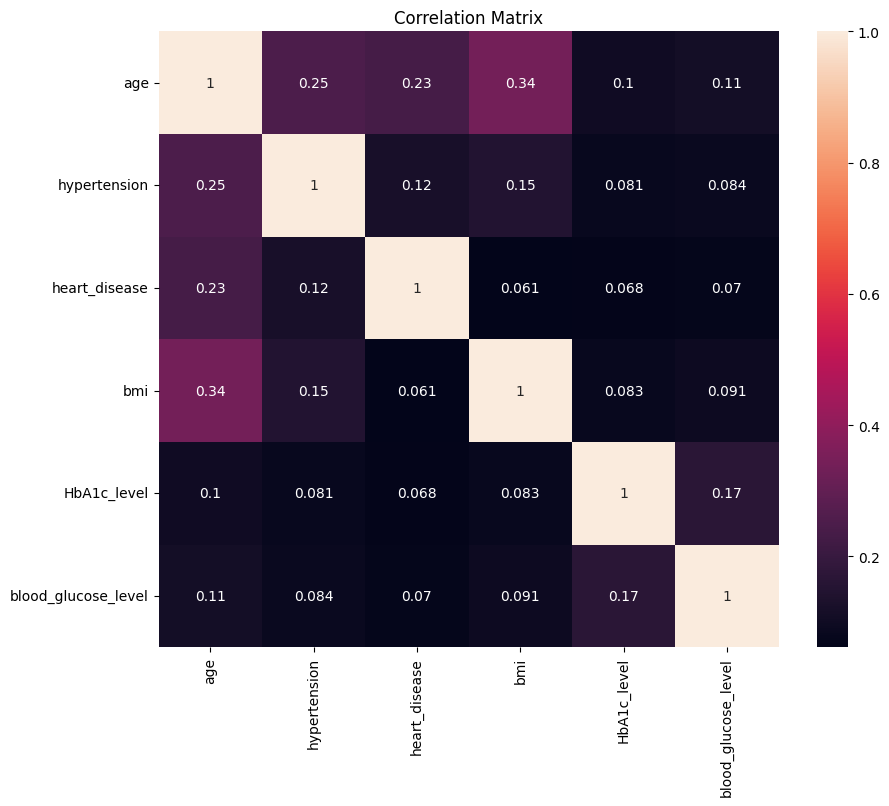

In [47]:
correlation_matrix = Correlation.corr(data, "features").head()
corr_matrix = correlation_matrix[0]
corr_df = pd.DataFrame(corr_matrix.toArray(), columns=feature_cols, index=feature_cols)


plt.figure(figsize=(10, 8))
sns.heatmap(corr_df,vmax=1.0,annot=True)
plt.title("Correlation Matrix")
plt.show()

In [48]:
train_data, test_data = data.randomSplit([0.8, 0.2], seed=123)

In [49]:
lr = LogisticRegression(labelCol=target_col, featuresCol="features")
model = lr.fit(train_data)

predictions = model.transform(test_data)

evaluator = MulticlassClassificationEvaluator(
    labelCol=target_col, predictionCol="prediction", metricName="accuracy"
)

In [50]:
s=[]
for i in range(1,10):
    
    train_data1, test_data1 = data.randomSplit([i/10, 1-(i/10)], seed=123)

    lr1 = LogisticRegression(labelCol=target_col, featuresCol="features")
    model1 = lr1.fit(train_data1)
    predictions1 = model.transform(test_data1)

    evaluator1 = MulticlassClassificationEvaluator(
        labelCol=target_col, predictionCol="prediction", metricName="accuracy"
    )
    accuracy1 = evaluator1.evaluate(predictions1)
    s.append(accuracy1)


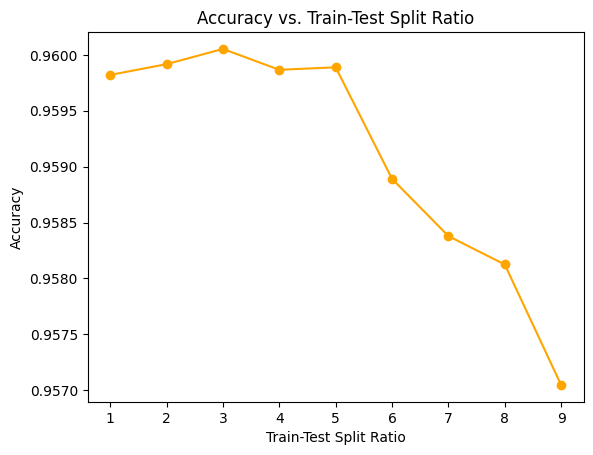

In [51]:
plt.plot(range(1, 10), s, marker='o',color = 'orange')
plt.title('Accuracy vs. Train-Test Split Ratio')
plt.xlabel('Train-Test Split Ratio')
plt.ylabel('Accuracy')
plt.show()

In [53]:
accuracy = evaluator.evaluate(predictions)
tp = predictions.filter("diabetes = 1 AND prediction = 1").count()
fp = predictions.filter("diabetes = 0 AND prediction = 1").count()
tn = predictions.filter("diabetes = 0 AND prediction = 0").count()
fn = predictions.filter("diabetes = 1 AND prediction = 0").count()
precision = tp / (tp + fp)
recall = tp / (tp + fn)
f1_score = 2 * (precision * recall) / (precision + recall)

print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1 Score: {f1_score}")

Accuracy: 0.9581246243237828
Precision: 0.8586345381526105
Recall: 0.6182764603817236
F1 Score: 0.718897108271688


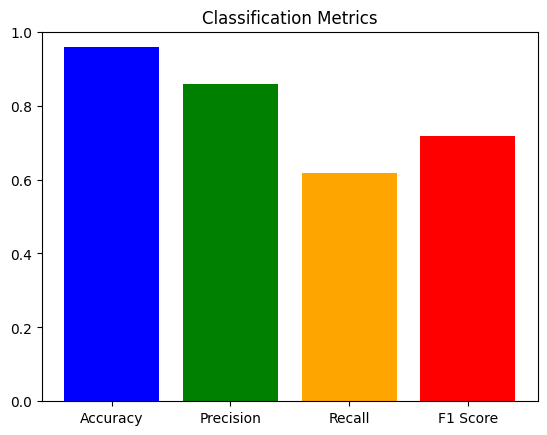

In [34]:
labels = ['Accuracy', 'Precision', 'Recall', 'F1 Score']
values = [accuracy, precision, recall, f1_score]

plt.bar(labels, values, color=['blue', 'green', 'orange', 'red'])
plt.ylim(0, 1)
plt.title('Classification Metrics')
plt.show()

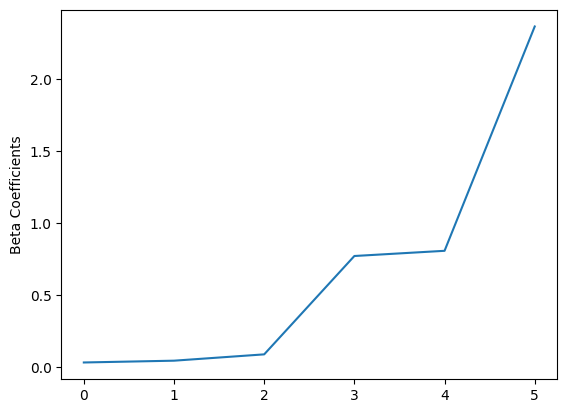

In [35]:
beta = np.sort(model.coefficients)
plt.plot(beta)
plt.ylabel('Beta Coefficients')
plt.show()

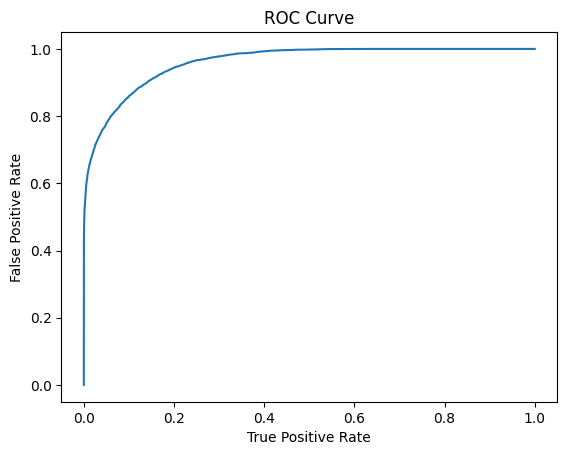

TrainSet areaUnderROC: 0.9609120132816392


In [36]:
trainSet = model.summary
roc = trainSet.roc.toPandas()
plt.plot(roc['FPR'],roc['TPR'])
plt.ylabel('False Positive Rate')
plt.xlabel('True Positive Rate')
plt.title('ROC Curve')
plt.show()
print('TrainSet areaUnderROC: ' + str(trainSet.areaUnderROC))

In [37]:
prediction_and_label = predictions.select("prediction", target_col).rdd.map(lambda row: (float(row.prediction), float(row[target_col])))

metrics = MulticlassMetrics(prediction_and_label)

confusion_matrix = metrics.confusionMatrix().toArray()
print("Confusion Matrix:")
print(confusion_matrix)


C:\Users\blruc\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\pyspark\sql\context.py:157: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  warnings.warn(


Confusion Matrix:
[[18059.   176.]
 [  660.  1069.]]


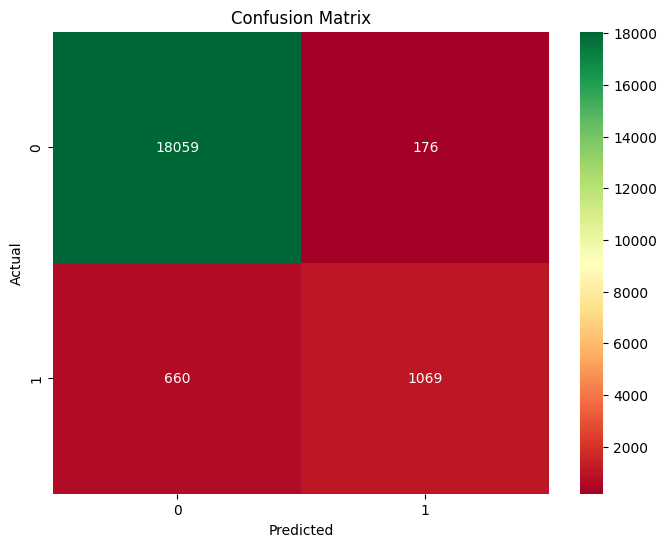

In [38]:
plt.figure(figsize=(8, 6))
sns.heatmap(confusion_matrix, annot=True, fmt=".0f", cmap=sns.color_palette("RdYlGn", as_cmap=True), cbar=True)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

In [39]:
predictions = model.transform(test_data)
predictions.show(10000)
spark.stop()

+----+------------+-------------+-----+-----------+-------------------+--------+--------------------+--------------------+--------------------+----------+
| age|hypertension|heart_disease|  bmi|HbA1c_level|blood_glucose_level|diabetes|            features|       rawPrediction|         probability|prediction|
+----+------------+-------------+-----+-----------+-------------------+--------+--------------------+--------------------+--------------------+----------+
|0.08|           0|            0|11.88|        5.7|                 80|       0|[0.08,0.0,0.0,11....|[10.2365148511792...|[0.99996416375290...|       0.0|
|0.08|           0|            0|12.29|        5.8|                140|       0|[0.08,0.0,0.0,12....|[7.93921161933015...|[0.99964363962265...|       0.0|
|0.08|           0|            0|12.89|        6.5|                145|       0|[0.08,0.0,0.0,12....|[6.06196979683735...|[0.99767560826647...|       0.0|
|0.08|           0|            0|13.03|        6.2|                158